## Split video

In [1]:
import cv2
import os

def is_folder_empty(folder_path):
    """Check if the folder is empty"""
    return len(os.listdir(folder_path)) == 0

def video_to_images(video_path, output_folder):
    """Split the video into multiple images and name them in the format 000001.jpg"""
    
    # Check if the output folder exists, if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Check if the output folder is empty
    if not is_folder_empty(output_folder):
        print(f"Folder {output_folder} is not empty, skipping video splitting.")
        return
    else:
        print(f"Folder {output_folder} is empty, starting video splitting.")
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    frame_number = 1  # Frame counter
    while cap.isOpened():
        ret, frame = cap.read()  # Read video frames
        if not ret:
            break  # Exit loop if no frames left
        
        # Generate the image filename, named in the format 000001.jpg, 000002.jpg...
        image_filename = f"{output_folder}/{frame_number:06d}.jpg"
        
        # Save the image
        cv2.imwrite(image_filename, frame)
        
        # print(f"Save image: {image_filename}")
        
        frame_number += 1
    
    # Release video resources
    cap.release()
    print("Finished.")

# Path to the video file
video_path = './videos/rubiks_cube.mp4'

# Path to the folder where the images will be saved
output_folder = './videos/rubiks_cube'

# Split the video into images and save them
video_to_images(video_path, output_folder)


Folder ./videos/rubiks_cube is not empty, skipping video splitting.


In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


## Select model

In [4]:
from sam2.build_sam import build_sam2_video_predictor

# sam2_checkpoint = "../checkpoints/sam2_hiera_tiny.pt"
# model_cfg = "sam2_hiera_t.yaml"
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

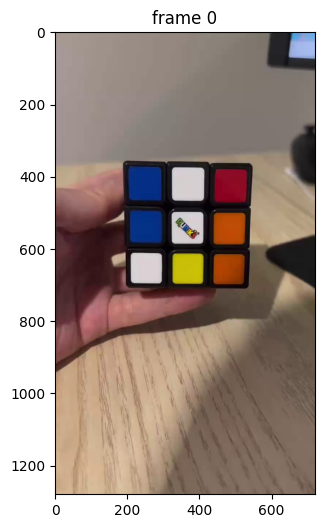

In [6]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/rubiks_cube"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
image = Image.open(os.path.join(video_dir, frame_names[frame_idx]))
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(image)

In [7]:
width, height = image.size
width, height

(720, 1280)

## Initialize the inference state

In [8]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|███████████████████████████████████████████████████████████| 336/336 [00:07<00:00, 45.97it/s]


In [9]:
predictor.reset_state(inference_state)

## Segment the object using box prompt

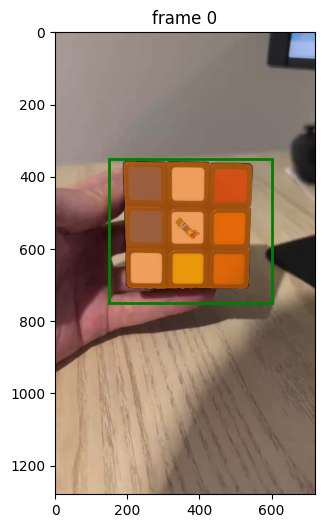

In [10]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

box = np.array([150, 350, 600, 750], dtype=np.float32)

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|█████████████████████████████████████████████████████████████| 336/336 [00:19<00:00, 17.13it/s]


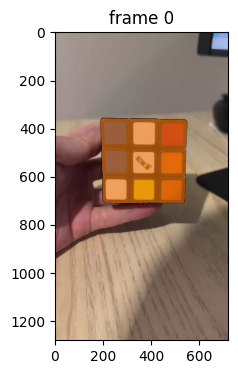

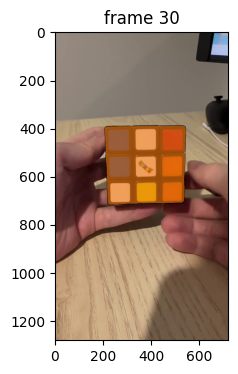

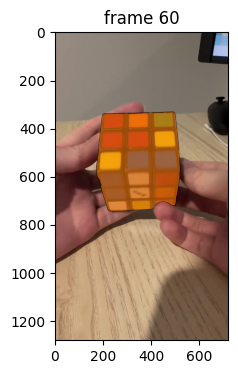

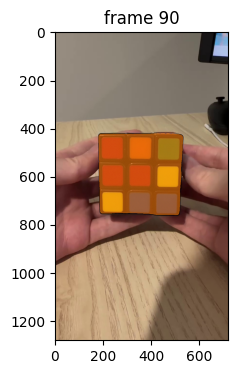

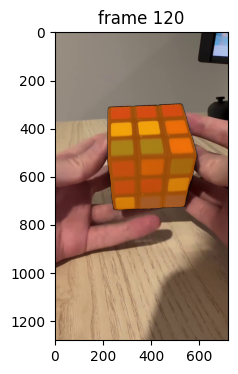

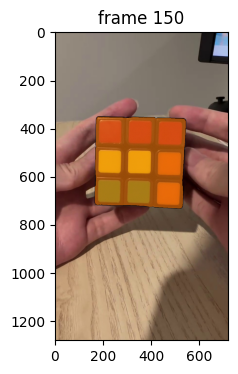

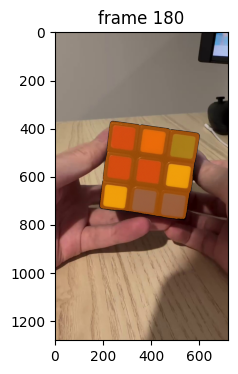

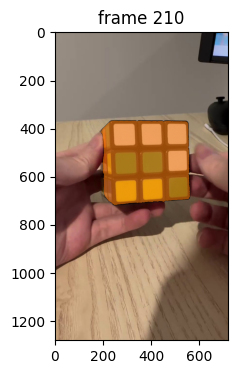

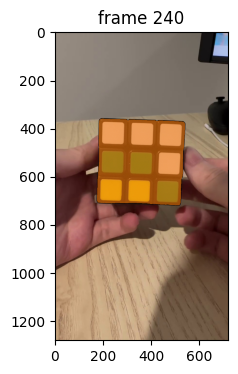

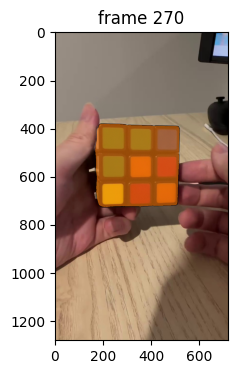

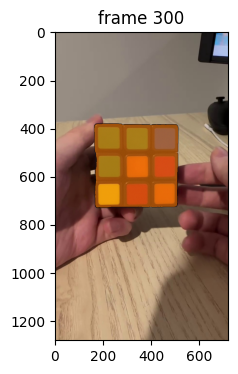

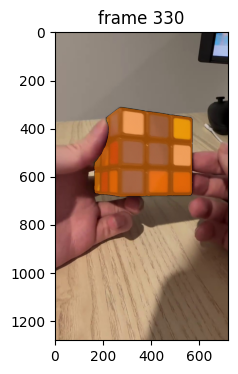

In [11]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [12]:
# for k, v in video_segments.items():
#     print(k,v)

In [13]:
# print(applied_masks_log)

## Rubik's Cube Face Extraction and Color Classification

In [14]:
import cv2
import os
import numpy as np

def extract_cube_face(image, mask):
    """Extract one face of the Rubik's cube using the mask and analyze its color block configuration"""
    # Convert mask to the correct shape and data type
    if mask.ndim == 3:
        mask = mask[0]  # Remove the first dimension to make it a 2D array
    
    # Ensure the mask is of uint8 type
    mask = mask.astype(np.uint8)
    
    # Find the bounding box of the mask
    true_indices = np.where(mask)
    min_y, max_y = np.min(true_indices[0]), np.max(true_indices[0])
    min_x, max_x = np.min(true_indices[1]), np.max(true_indices[1])
    
    # Calculate the width and height of the masked region
    mask_h = max_y - min_y + 1
    mask_w = max_x - min_x + 1

    # Debug output
    # print(f"Bounding box of the mask: X=({min_x}, {max_x}), Y=({min_y}, {max_y}), Width={mask_w}, Height={mask_h}")
    
    # Split the masked region into 9 color blocks
    block_size_h = mask_h // 3  # Divide the height into 3 equal parts
    block_size_w = mask_w // 3  # Divide the width into 3 equal parts

    face_colors = []

    # Define the proportion for the center region
    center_factor = 0.4  # Extract 75% of the center area for each block

    # Iterate over the 3x3 block area and analyze the dominant color of each block
    for row in range(3):
        for col in range(3):
            # Extract each block's region (based on the mask's bounding box)
            y1 = min_y + row * block_size_h
            y2 = min_y + (row + 1) * block_size_h
            x1 = min_x + col * block_size_w
            x2 = min_x + (col + 1) * block_size_w
            block = image[y1:y2, x1:x2]  # Extract the corresponding block from the original image

            # Further extract the center 75% of each block to avoid black edges
            center_y1 = int((1 - center_factor) / 2 * block_size_h)
            center_y2 = int((1 + center_factor) / 2 * block_size_h)
            center_x1 = int((1 - center_factor) / 2 * block_size_w)
            center_x2 = int((1 + center_factor) / 2 * block_size_w)

            center_block = block[center_y1:center_y2, center_x1:center_x2]

            # Debug output to show the size of the center region
            # print(f"Row {row}, Column {col} center region size: Height={center_y2-center_y1}, Width={center_x2-center_x1}")
            
            # Calculate the dominant color of the block (simple method: calculate RGB mean)
            avg_color = np.mean(center_block, axis=(0, 1))  # Calculate the mean RGB value of each block
            # print(f"Row {row}, Column {col} average RGB color: {avg_color}")

            face_colors.append(avg_color)

    return face_colors

def classify_color(rgb_color):
    """Classify an RGB color into a Rubik's cube color"""
    r, g, b = rgb_color
    # print(f"Classifying color: R={r}, G={g}, B={b}")
    # Use simple color classification logic to distinguish the main colors of the Rubik's cube
    if 90 <= r <= 170 and 0 <= g <= 50 and 0 <= b <= 60:
        return "r"  # Red
    elif 0 <= r <= 100 and 70 <= g <= 255 and 0 <= b <= 100:
        return "g"  # Green
    elif 0 <= r <= 100 and 0 <= g <= 100 and 80 <= b <= 255:
        return "b"  # Blue
    elif 120 <= r <= 255 and 120 <= g <= 255 and 0 <= b <= 80:
        return "y"  # Yellow
    elif 120 <= r <= 255 and 125 <= g <= 255 and 140 <= b <= 255:
        return "w"  # White
    elif 100 <= r <= 255 and 50 <= g <= 200 and 0 <= b <= 100:
        return "o"  # Orange
    else:
        return "?"  # Unknown color or gray area

def get_cube_configuration(image, mask):
    """Get the color configuration of the current Rubik's cube face"""
    face_colors = extract_cube_face(image, mask)  # Extract the color of each block
    cube_face_config = ''.join([classify_color(color) for color in face_colors])
    # print(f"Rubik's cube configuration: {cube_face_config}")
    return cube_face_config


def is_square(mask, frame_index, obj_id):
    """Determine if the mask is approximately square"""
    if mask.ndim == 3:
        mask = mask[0]  # Remove the first dimension, making it a 2D array

    true_indices = np.where(mask)
    
    if len(true_indices[0]) == 0 or len(true_indices[1]) == 0:
        return False
    
    min_y, max_y = np.min(true_indices[0]), np.max(true_indices[0])
    min_x, max_x = np.min(true_indices[1]), np.max(true_indices[1])
    
    w = max_x - min_x + 1
    h = max_y - min_y + 1

    if h == 0 or w == 0:
        return False
    
    aspect_ratio = w / h
    is_square_flag = 0.98 <= aspect_ratio <= 1.02
    
    return is_square_flag

def calculate_frame_difference(frame1, frame2, threshold_ratio=2.6):
    """Calculate the difference between two frames and return if there is a significant change (by ratio)"""
    diff = cv2.absdiff(frame1, frame2)
    non_zero_count = np.count_nonzero(diff)
    
    total_pixels = frame1.shape[0] * frame1.shape[1]
    difference_ratio = non_zero_count / total_pixels
    # print(f"Difference ratio between two frames: {difference_ratio:.4f} (Threshold: {threshold_ratio})")
    
    return difference_ratio > threshold_ratio

def process_video_segments(video_segments, frame_names, video_dir, step=5):
    """Process each frame, determine if it shows a new face, and read the Rubik's cube configuration"""
    previous_frame = None  # Store the previous frame
    cube_configurations = set()
    for frame_index in range(0, len(frame_names), step):
        frame_name = frame_names[frame_index]
        
        # Read the corresponding frame image
        # frame_image = cv2.imread(os.path.join(video_dir, frame_name))
        frame_image = Image.open(os.path.join(video_dir, frame_name))
        frame_image = np.array(frame_image.convert("RGB"))
        
        
        # If the previous frame exists, calculate the difference with the current frame to reduce redundant processing
        if previous_frame is not None:
            if not calculate_frame_difference(previous_frame, frame_image):
                # print(f"Frame {frame_index} is similar to the previous frame, skipping processing.")
                continue

        # Process the mask of the current frame
        if frame_index in video_segments:
            segments = video_segments[frame_index]
            for obj_id, mask in segments.items():
                if is_square(mask, frame_index, obj_id):
                    # print(f"Frame {frame_index}, Object ID {obj_id} is considered square, applying mask.")
                    # plt.figure(figsize=(20, 20))
                    # plt.imshow(frame_image)
                    # plt.axis('off')
                    # plt.show()
                    # Extract Rubik's cube configuration from the masked region
                    cube_configuration = get_cube_configuration(frame_image, mask)
                    # print(f"The configuration of this Rubik's cube face is: {cube_configuration}")
                    cube_configurations.add(cube_configuration)
                # else:
                #     print(f"Frame {frame_index}, Object ID {obj_id} is not square, skipping.")

        # Update the previous frame
        previous_frame = frame_image
    return cube_configurations

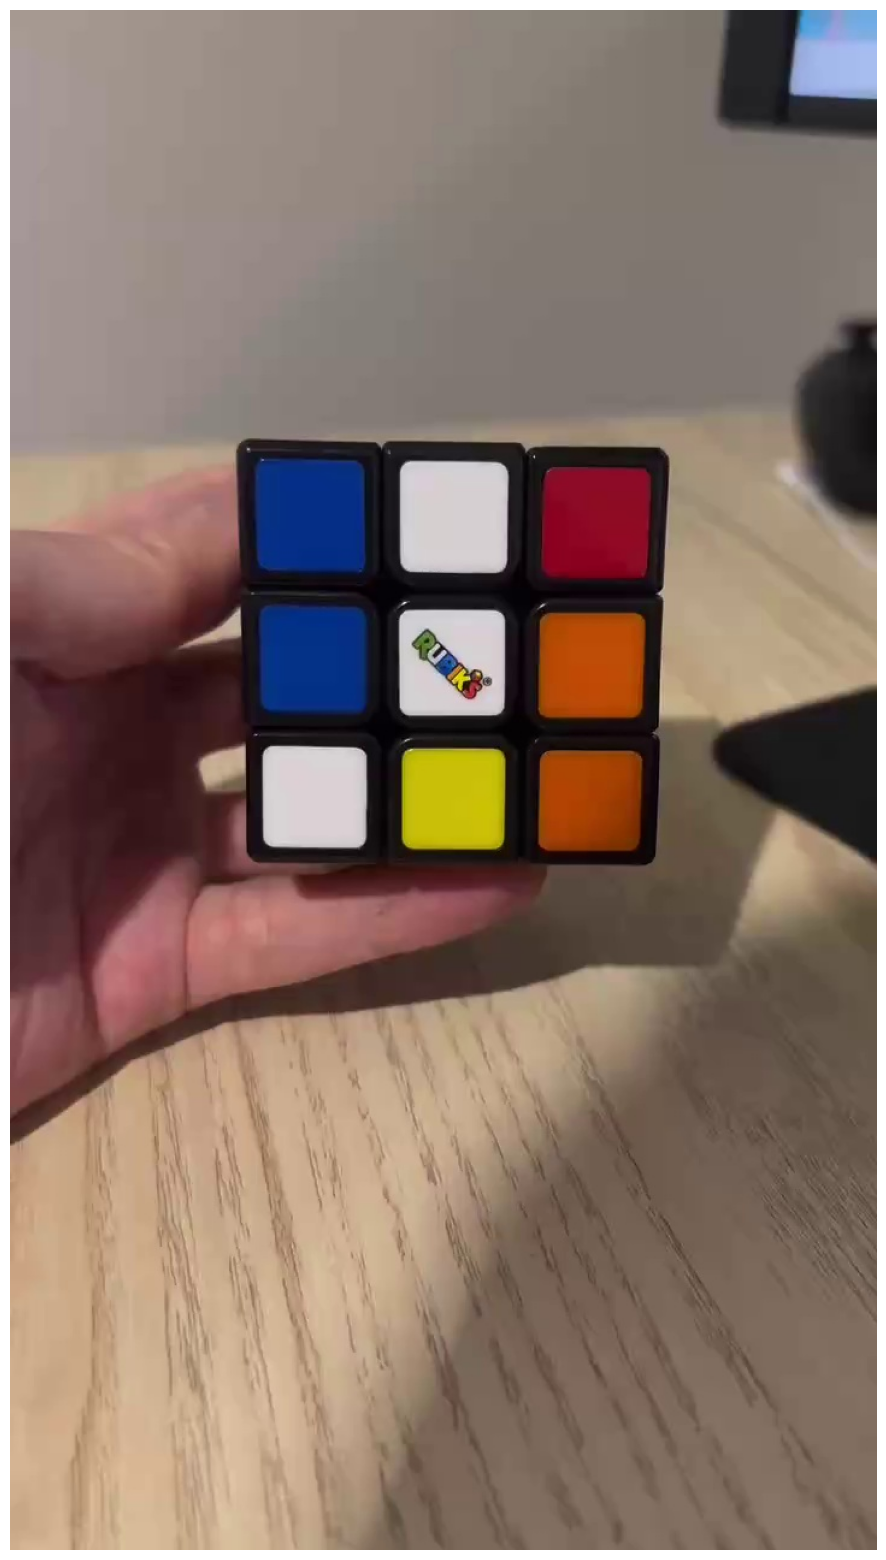

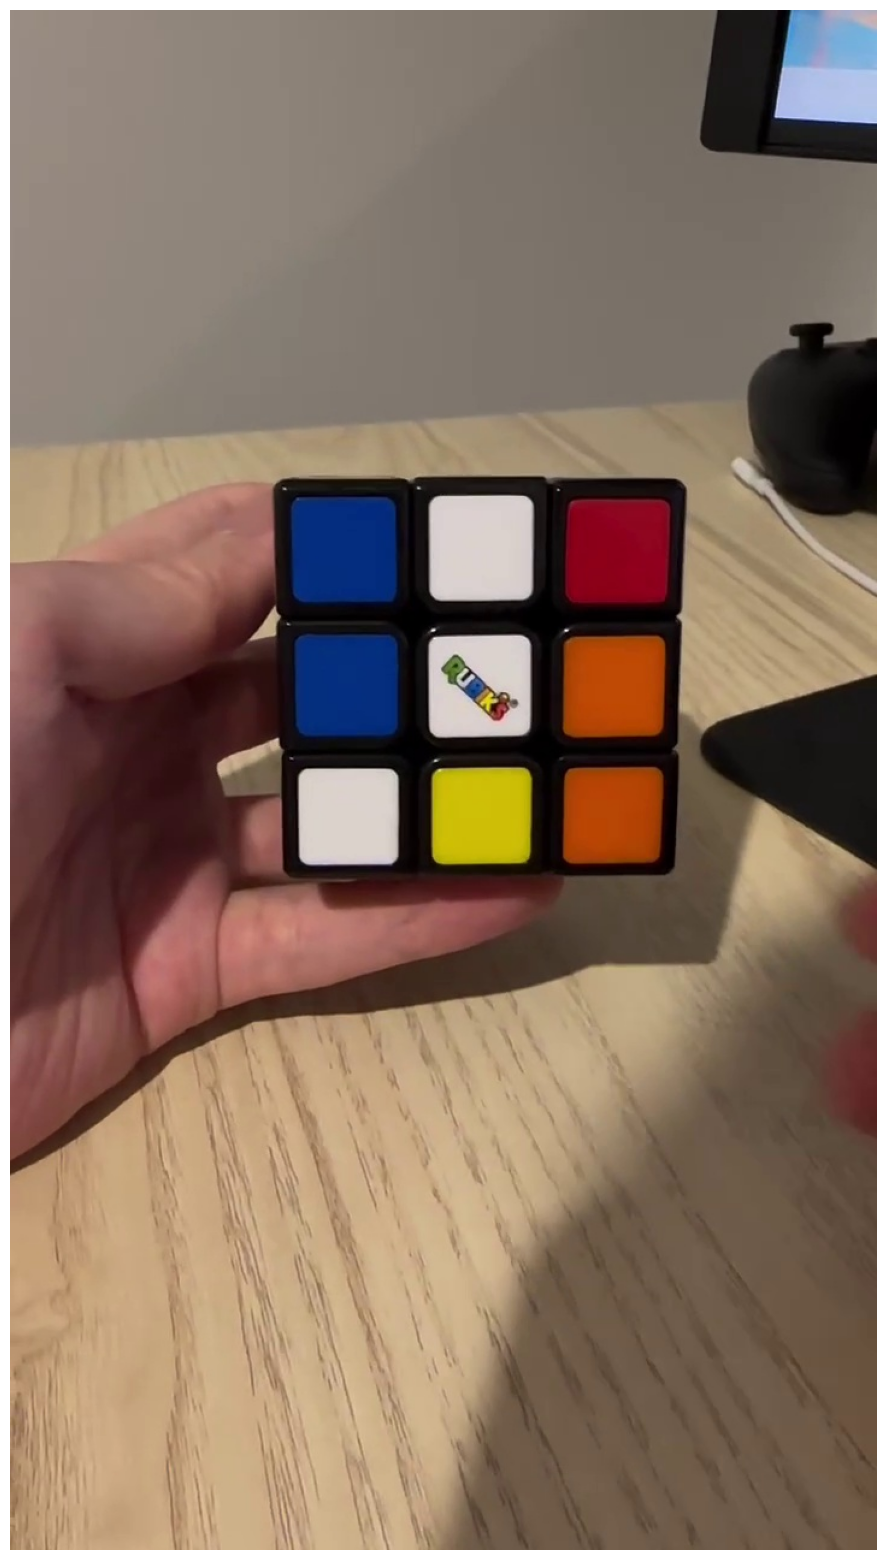

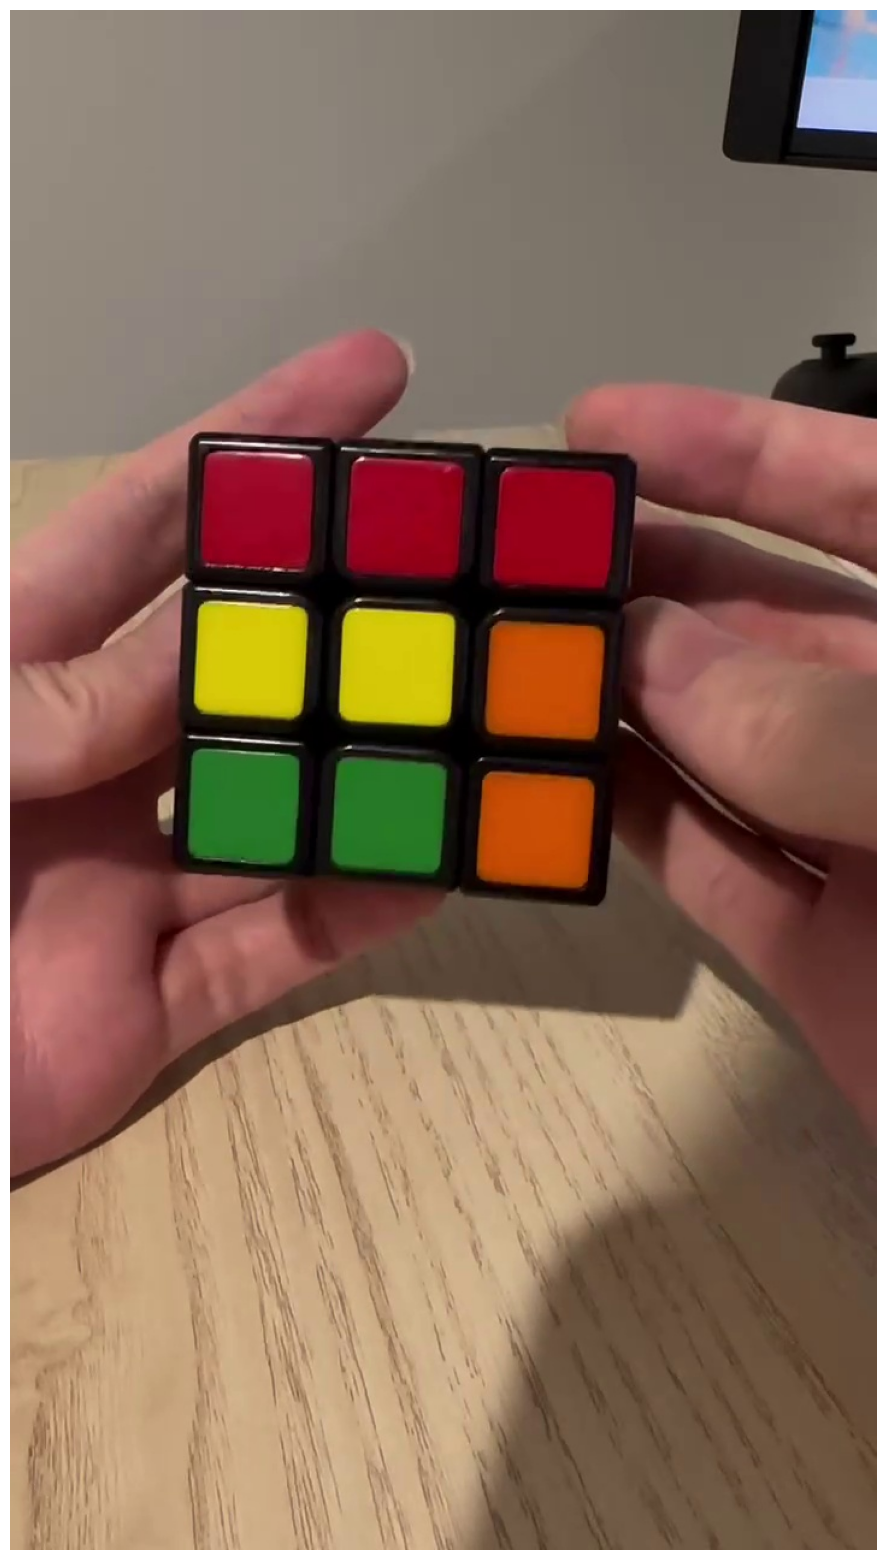

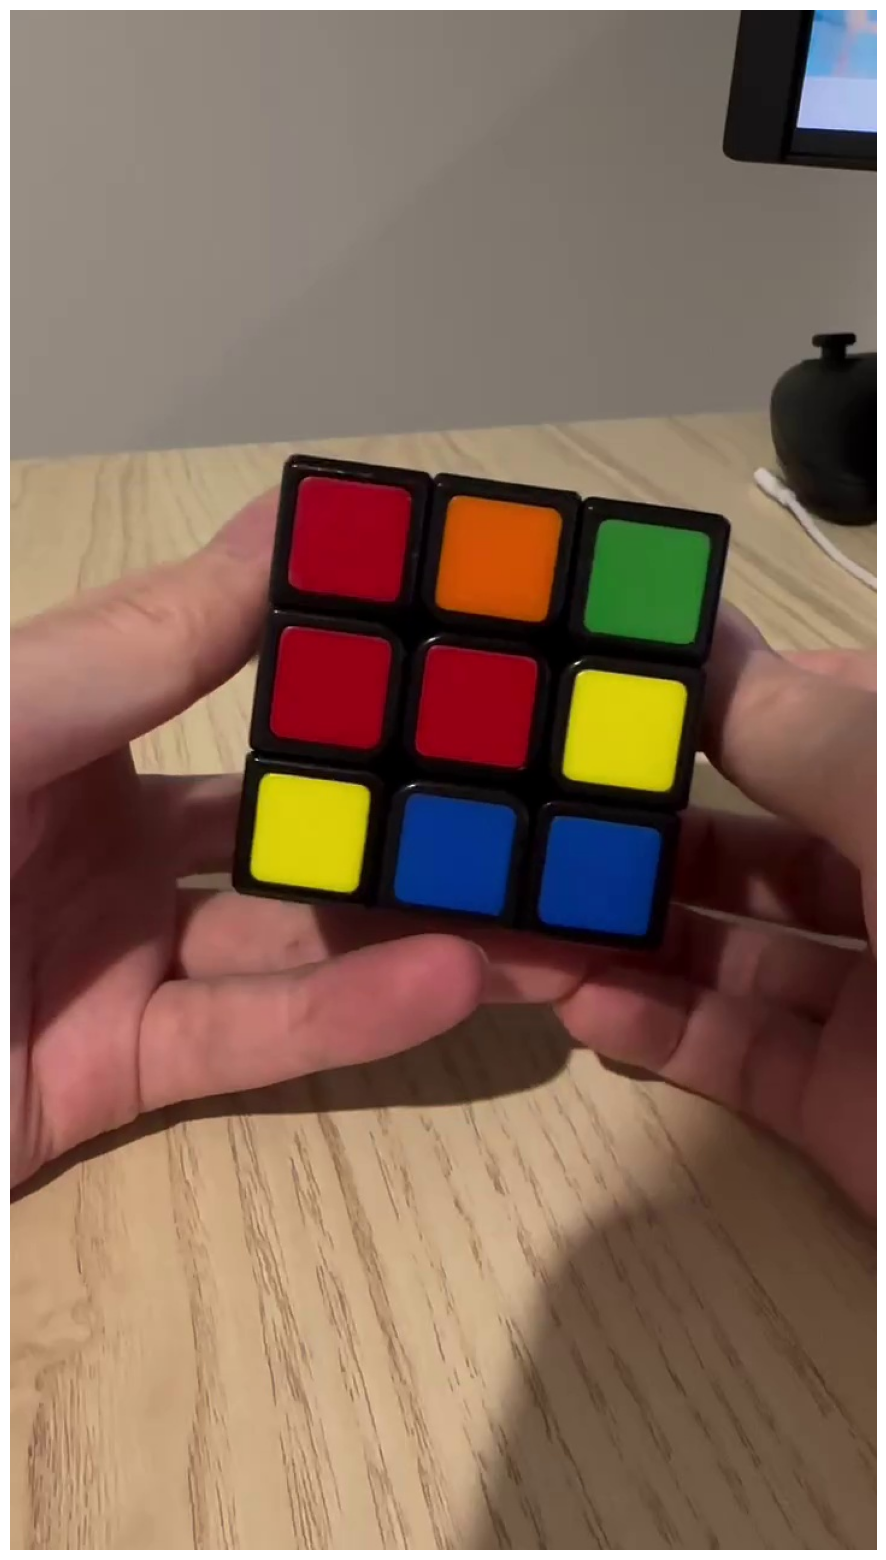

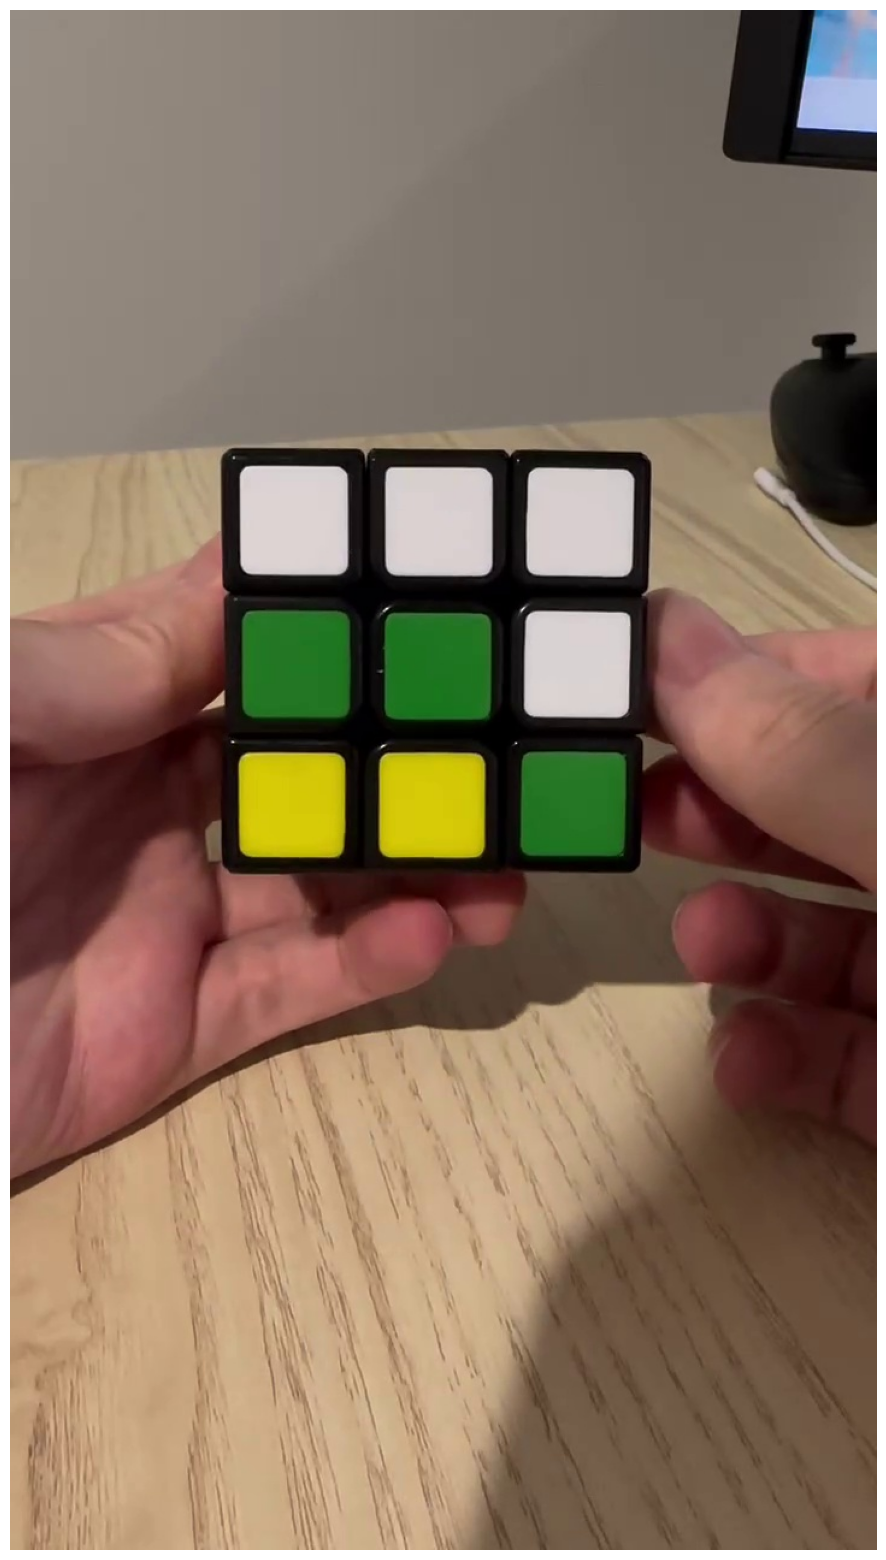

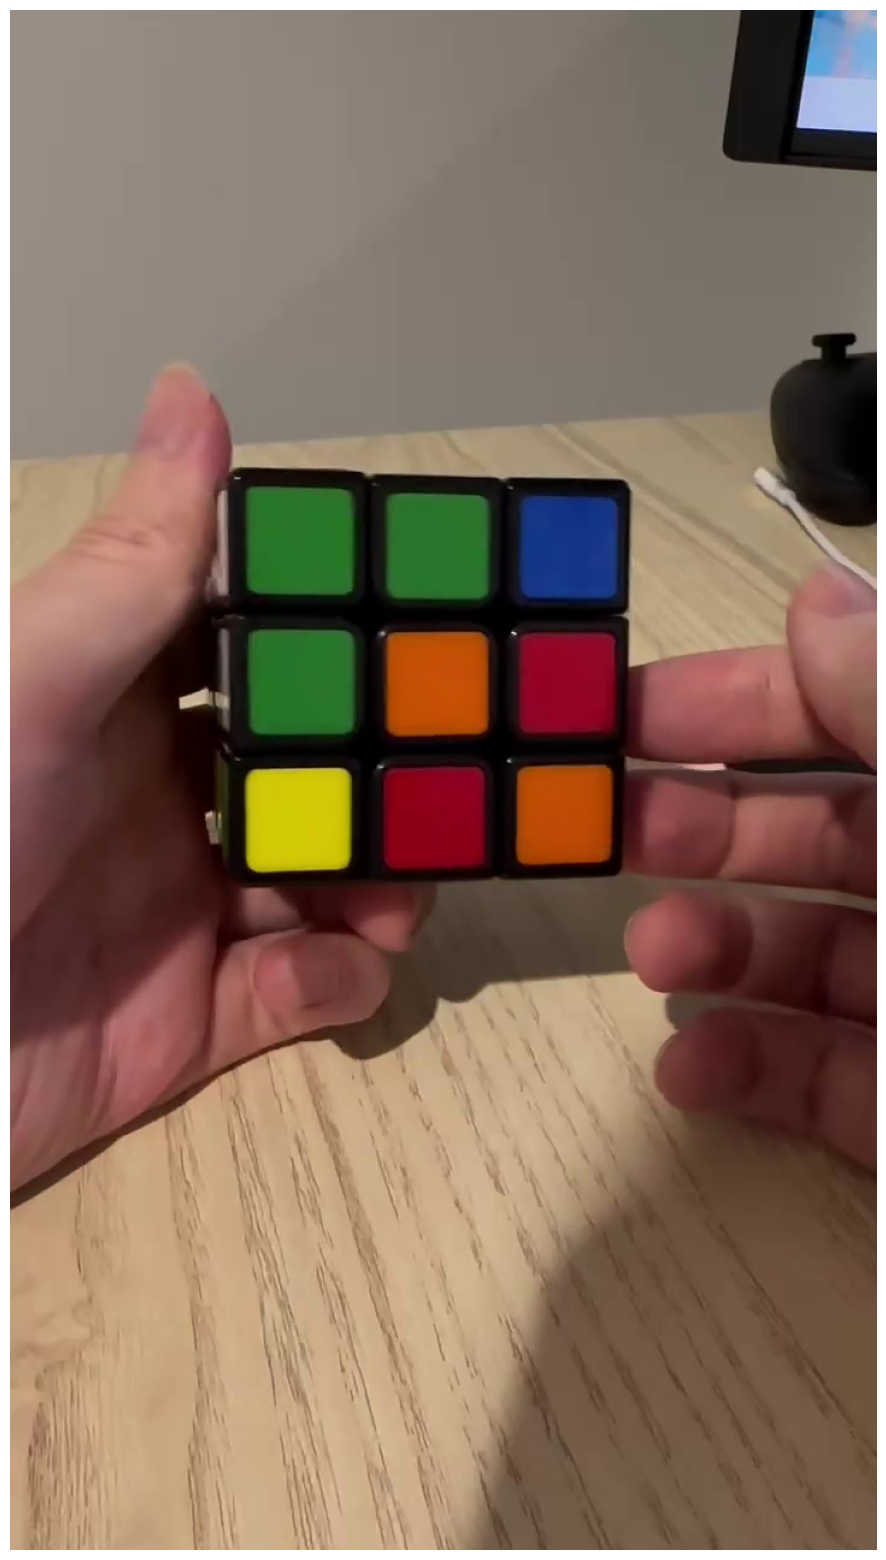

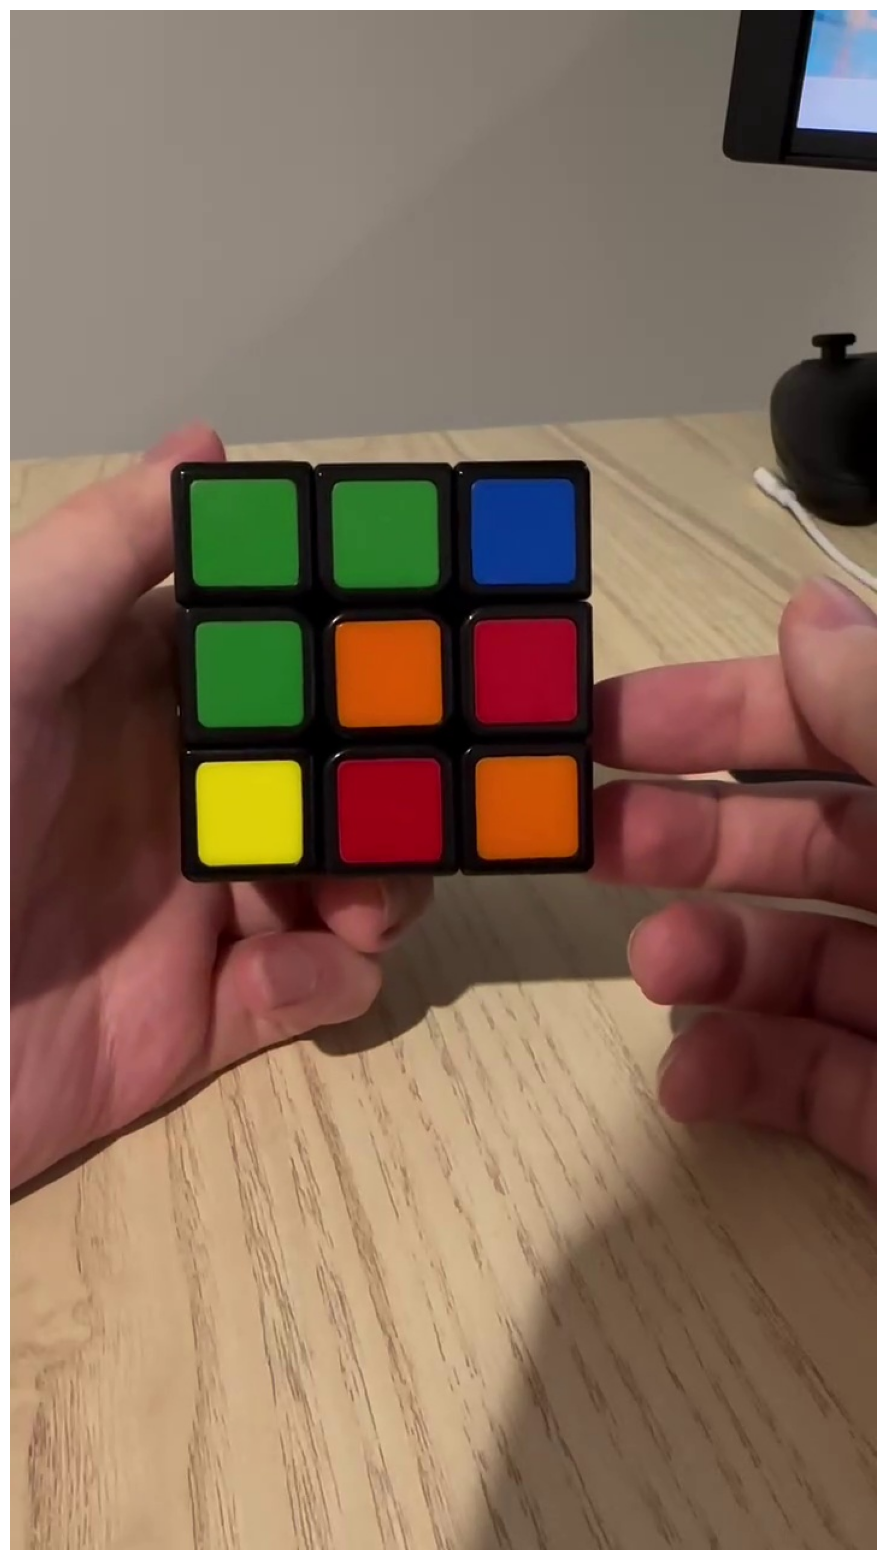

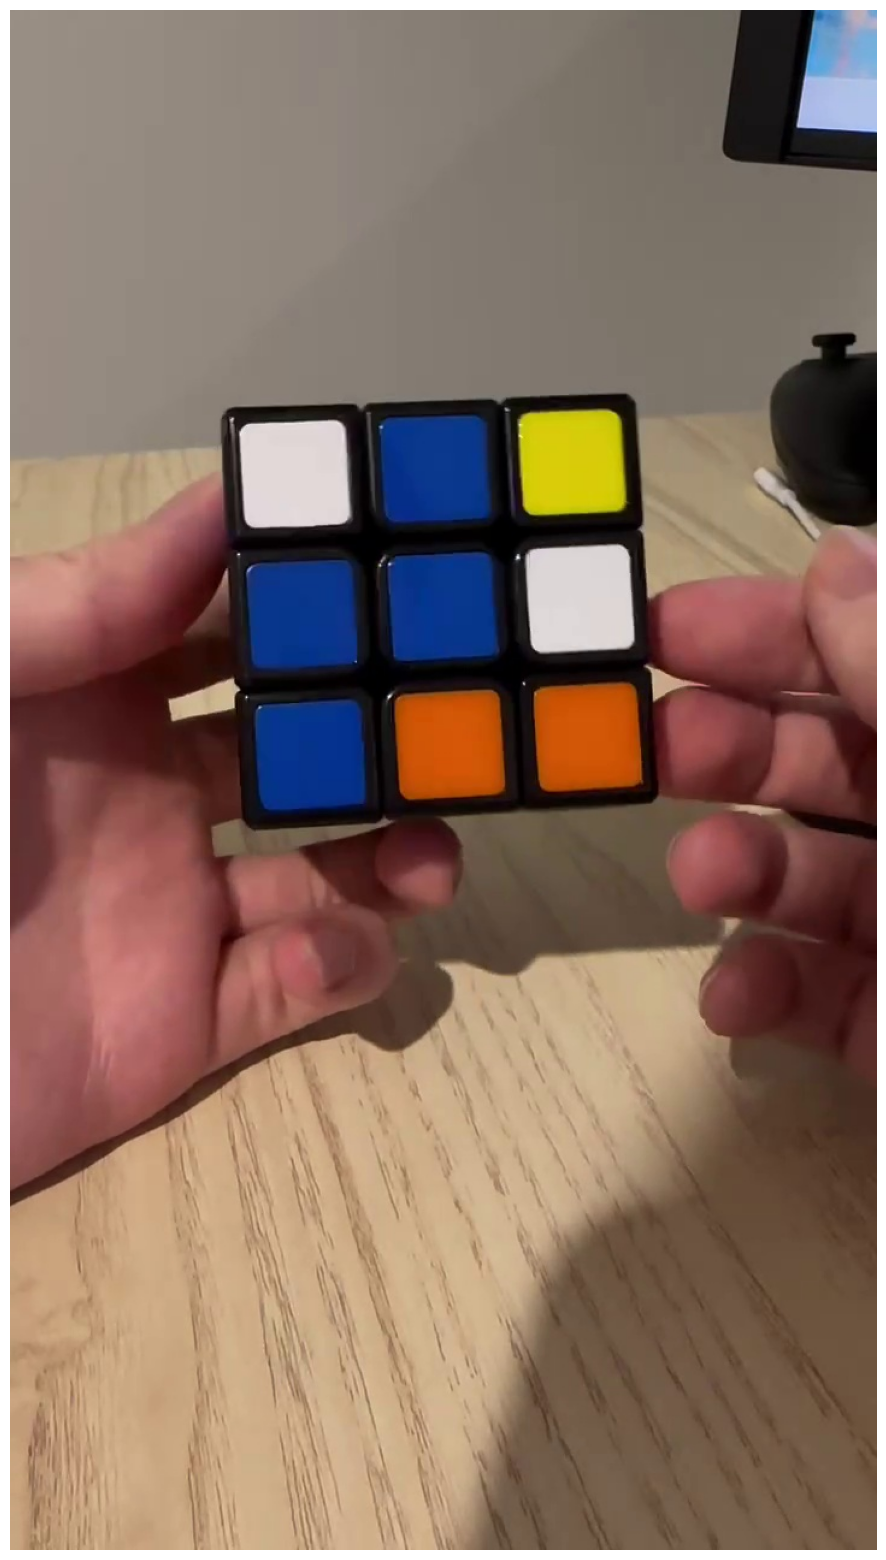

{'bwrbwowyo', 'ggbgoryro', 'rogrryybb', 'rrryyoggo', 'wbybbwboo', 'wwwggwyyg'}

In [15]:
cube_configuration = process_video_segments(video_segments, frame_names, video_dir, step=5)
cube_configuration

## Rubik's Cube Color Configuration Sorting and Conversion for kociemba

In [16]:
color_order = ['y', 'g', 'r', 'w', 'b', 'o']

# Extract the center color block of each face (the 5th character) and pair it with the entire face configuration
config_with_centers = [(face[4], face) for face in cube_configuration]

# Sort based on the order of the center color blocks
sorted_config = sorted(config_with_centers, key=lambda x: color_order.index(x[0]))

# Extract the sorted face configurations
sorted_faces = [face for _, face in sorted_config]

# Concatenate the sorted faces into the final string
config_str = ''.join(sorted_faces)

# Output the final result
print(f"The concatenated string after sorting is: {config_str}")

The concatenated string after sorting is: rrryyoggowwwggwyygrogrryybbbwrbwowyowbybbwbooggbgoryro


In [17]:
center_color_map = {
        'w': 'D',  
        'r': 'F',  
        'g': 'R',  
        'y': 'U',  
        'o': 'B',  
        'b': 'L'   
    }

In [18]:
new_config_str = ""
for c in config_str:
    if c in center_color_map:
        new_config_str += center_color_map[c]
# Output the converted Rubik's cube state
print(f"The converted Rubik's cube state is: {new_config_str}")

The converted Rubik's cube state is: FFFUUBRRBDDDRRDUURFBRFFUULLLDFLDBDUBDLULLDLBBRRLRBFUFB


In [19]:
import kociemba

kociemba.solve(new_config_str)

"B' R D F B' R2 D2 B2 U2 D2 L2 U2 F2 R2"